In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


from trajectory import Atom, Topology, FakeTrajectory

from os import listdir
from os.path import isfile, join

In [3]:
xs, ys = [[],[]], [[],[]]

phases = ["Lo", "Ld"]
LO = 0
LD = 1

for i in range(2):
    phase = phases[i]
    
    path = "trajectories/%s/" % phase
    files = [f for f in listdir(path) if isfile(join(path, f)) and not f[0] == '.' ] 
    
    counter = 0
    for file in files:
        counter += 1
#         print("Importing %s" % path+file)
        x, y = np.loadtxt(path + file, unpack=True)
        xs[i].append(x)
        ys[i].append(y)
        print("Imported %d timesteps of data. (%d of %d)    " % (len(x), counter, len(files)), end="\r")
        
# x, y = np.loadtxt(path + files[1], unpack=True)
# xs.append(x)
# ys.append(y)

In [5]:
import pickle
# traj = pickle.load(open('/home/jd/phd/virtual_fcs/D15.pkl', 'rb'))
traj = pickle.load(open('/home/jd/phd/virtual_fcs/D4.pkl', 'rb'))
pxs = traj.xyz[:,:,0].T
pys = traj.xyz[:,:,1].T

In [6]:
print(traj.xyz.shape)
print(traj.xyz[:,:,0].T.shape)

(50000, 500, 3)
(500, 50000)


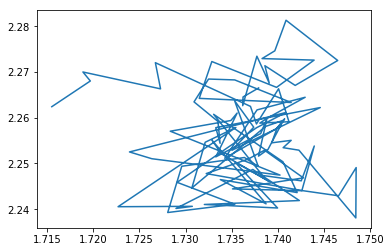

In [7]:
plt.plot(xs[0][1][:100], ys[0][1][:100])

# Find the longest trajectory
maxlen = min([len(x) for x in xs[0]])
# print(minlen)

# MSD Analysis

## Calculate MSD

In [8]:
def MSD(traj):
    
    _MSDs = []
    
    start = traj.__next__()
    for cur in traj:
        
        _MSD = (cur[0] - start[0])**2 + (cur[1] - start[1])**2
        
        _MSDs.append(_MSD)
        
    return _MSDs

### Random Walker

Calculates the array of random walker MSDs ```pMSDs[walker][timestep]``` and the array of ensemble-averaged MSDs ```p_avg[timestep]```

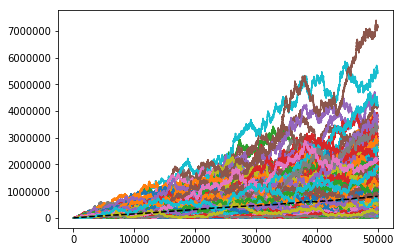

In [9]:
_trajectories = [zip(pxs[t], pys[t]) for t in range(len(pxs))]

pMSDs = [MSD(t) for t in _trajectories]

p_avg = np.mean(pMSDs, axis=0)

for p in pMSDs:
    plt.plot(p)
    
plt.plot(p_avg, 'k--')

### SPT Data

Calculates the list of SPT particle trajectory ```MSDs[Phase][trajectory][timestep]``` 
and the list of averaged MSDs for each phase, ```Lo_avg[timestep]``` and ```Ld_avg[timestep]```

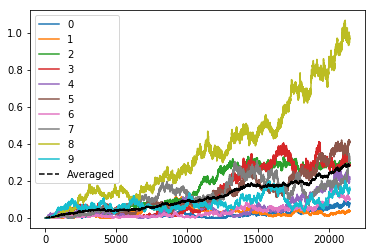

In [10]:
# MSDs = np.array(shape=(10,maxlen))

# Need to subtract 1, because the MSD necessarily drops the first step since it's finding differences
Lo_minlen = min([len(x) for x in xs[LO]]) - 1
Ld_minlen = min([len(x) for x in xs[LD]]) - 1
minlens = (Lo_minlen, Ld_minlen)


MSDs = [[],[]]


# For each phase...
for i in range(2):
    
    minlen = minlens[i]
    
    # Get zipped sets of (x[t],y[t]) trajectories
    trajectories = [zip(xs[i][t],ys[i][t]) for t in range(len(xs[i]))]
    
    MSDs[i] = [MSD(t) for t in trajectories]
    
    MSDs[i] = [_MSD[:minlen] for _MSD in MSDs[i]]
    

# Ensemble average the MSDs for each phase
# Subdiffusion happens below 1ms, which corresponds to 50 timesteps (20 microseconds each)
Lo_avg = np.mean(MSDs[LO], axis=0)#[:50/time_average_step]
Ld_avg = np.mean(MSDs[LD], axis=0)#[:50/time_average_step]

for i, traj in enumerate(MSDs[LO]):
#     print(len(traj))
    plt.plot(traj, label=i)
    
    
plt.plot(Lo_avg, 'k--', label="Averaged")
plt.legend()

## Plot averaged MSDs

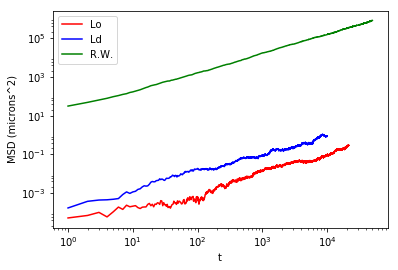

In [10]:
plt.loglog(Lo_avg, 'r-', label="Lo")
plt.loglog(Ld_avg, 'b-', label="Ld")

plt.loglog(p_avg, 'g-', label="R.W.")

plt.xlabel("t")
plt.ylabel("MSD (microns^2)")
plt.legend()

In [11]:
#Subdiffusion happens below 1ms, which corresponds to 50 timesteps (20 microseconds each)
# np.savetxt("Ld.csv", Ld_avg)
# np.savetxt("Lo.csv", Lo_avg)

## Fit to Fickian MSD

Now, fit to the MSD curve to determine the diffusion constant.

Fickian diffusion is given by $<r^2> = D t^\alpha $

In [12]:
def calc_msd_a(t, D, a):
    return D * (t ** a)

def calc_msd(t, D):
    return 4*D*t

### Calculate D for the averaged MSD

In [13]:
phase = LO

# traj = np.mean(MSDs[phase], axis=0)
traj = p_avg


_t = np.arange(1E-8, len(traj))
_r = traj

popt, pcov = curve_fit(calc_msd, _t, _r, p0=(1))
perr = np.sqrt(np.diag(pcov))

D = 3.893e+00 +/- 3.350e-04


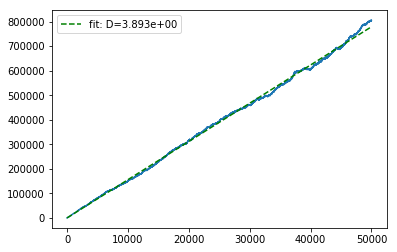

In [14]:
print('D = %5.3e +/- %5.3e' % (popt[0], perr[0]))
# print('a = %5.3e +/- %5.3e' % (popt[1], perr[1]))

plt.plot(_r)
# plt.plot(_t, msd(_t, *popt), 'g--', label='fit: D=%5.3e, a=%5.3f' % tuple(popt
plt.plot(_t, calc_msd(_t, *popt), 'g--', label='fit: D=%5.3e' % tuple(popt))
plt.legend()

### Calculate MSDs of each trajectory, then average

D = 7.332e+00 +/- 6.821e-03


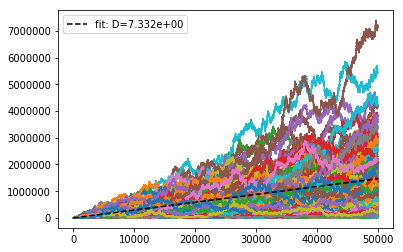

In [15]:
Ds = []
errs = []

# for traj in MSDs[phase]:
for traj in pMSDs:

    _t = np.arange(1E-8, len(traj))
    _r = traj

    popt, pcov = curve_fit(calc_msd, _t, _r, p0=(1))
    perr = np.sqrt(np.diag(pcov))
    
    Ds.append((popt[0]))
    errs.append((perr[0]))
#     Ds.append((popt[0], popt[1]))
#     errs.append((perr[0], perr[1]))

    plt.plot(traj)
    
# print(Ds)
# print(errs)

print('D = %5.3e +/- %5.3e' % (popt[0], perr[0]))
# print('a = %5.3e +/- %5.3e' % (popt[1], perr[1]))

plt.plot(_r)
# plt.plot(_t, msd(_t, *popt), 'g--', label='fit: D=%5.3e, a=%5.3f' % tuple(popt))
plt.plot(_t, calc_msd(_t, *popt), 'k--', label='fit: D=%5.3e' % tuple(popt))
plt.legend()

# Step Length Analysis

Calculates an array of N-1 step lengths for a trajectory of N (x, y) positions

In [16]:
def calc_step_length(traj):
    
    _step_lengths = []
    
    prev = traj.__next__()
    for cur in traj:
        
        step = (cur[0] - prev[0])**2 + (cur[1] - prev[1])**2
        
        _step_lengths.append(step)
        
        prev = cur
        
    return np.array(_step_lengths)

## Random walker

[ 2.65162585  9.75836727 10.67696179 ... 19.26089973 15.16876903
 13.45627561]
15.999632937271839
7.999720558438703
D = 4.000e+00


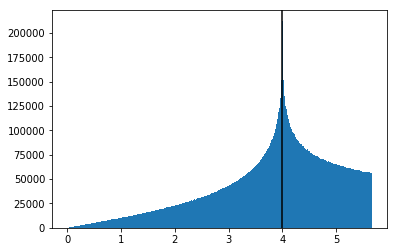

In [17]:
p_step_lengths = np.ndarray(len(pxs), dtype=np.ndarray)

for w in range(0, len(pxs)):
    
    traj = zip(pxs[w], pys[w])
    
    _step_lengths = calc_step_length(traj)
    
    p_step_lengths[w] = _step_lengths
    
    
print(p_step_lengths[0])
    
p_flat = np.hstack(p_step_lengths)

# print(p_flat)

n, _bins, patches = plt.hist(np.sqrt(p_flat), bins='auto')
plt.gca().axvline(np.sqrt(np.mean(p_flat)), color='k')
print(np.mean(p_flat))
print(np.std(p_flat))
 
print("D = %.3e" % (np.mean(p_flat) / 4.)) 

## Calculate step lengths for SPT data

0.0001297457184256387
0.00014495685517335115
D = 3.244e-05


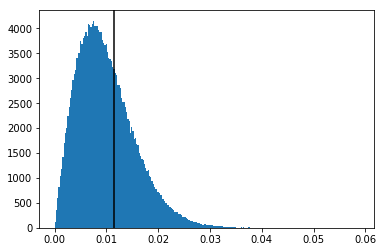

In [18]:
phase = LD

step_lengths = np.ndarray(len(xs[phase]), dtype=np.ndarray)

for t in range(0,len(xs[phase]),1):
    
    traj = zip(xs[phase][t], ys[phase][t])
    
    step_lengths[t] = calc_step_length(traj)
    
flat = np.hstack(step_lengths)

n, _bins, patches = plt.hist(np.sqrt(flat), bins='auto')
plt.gca().axvline(np.sqrt(np.mean(flat)), color='k')
print(np.mean(flat))
print(np.std(flat))
 
print("D = %.3e" % (np.mean(flat) / 4.)) # Add a factor of *20 for the SPT sampling rate?

# Analyzing Data with Autocorrelation Fit

Function to generate the value of an autocorrelation using the MSD and beam width $w$.

$G(\tau) = \left ( 1 + \langle MSD \rangle / w^2 \right )^{-1}$

In [11]:
# Generate autocorrelation at a time lag tau given an MSD at that time and a spot size

def acorr(tau, _MSD, w):
    
    G = 1./(1 + _MSD/(w**2))
    
    return G

In [ ]:
print(Lo_avg)
print(acorr(1, Lo_avg, 59))

The code below uses the list of ensemble averaged MSDs to calculate an MSD from the form above.

The G=0.5 crossing time is found for each beam width ```w``` in ```w_range```
Then, the diffusion constant is calculated for each beam width.

For the SPT trajectories, an additional unit conversion must be done since the timesteps are not 1

49999
Average diffusion constant was 3.95e+00 +- 1.30e-01


/home/jd/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


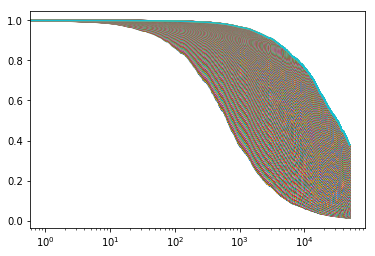

In [35]:
_traj = p_avg
# _traj = Lo_avg
# _traj = Ld_avg

print(len(_traj))
ts = np.arange(1,len(_traj))
w_range = np.linspace(100,700,500) #For MSD
# w_range = np.linspace(.05,.5,50) # For Lo

time_scaling = 1 # for MSD
# time_scaling = 1./5. # for Lo ??? 

plt.xscale('log')

calced_Ds = []

for w in w_range:
    
    print("Calculating for w = %.2e" % w, end='\r')

    # Experimental reshaping of acorrs to fill 0-1
    acorrs = [acorr(t, _traj[t], w) for t in ts]


    # acorrs = list(map(lambda x: acorr(x, pMSDs[3][x], w), ts))


    # acorrs -= min(acorrs)
#     print(acorrs)
#     print(max(acorrs))
    acorrs /= max(acorrs)

    plt.plot(acorrs)

    # print(acorrs[0])
    # print(acorrs[-1])

    crossing = 0
    for x in range(len(acorrs)):
        if acorrs[x] < 0.5:
#             print("Crossing at tau = %d" % x)
#             print("Previous: {}, Current: {}".format(acorrs[x-1], acorrs[x]))
            crossing = x
            break
            
    
    calced_D = w**2 / (4. * crossing) * time_scaling

#     print("\nCalculated D: %.3e" % calced_D)

    calced_Ds.append(calced_D)
    
# print(calced_Ds)
avgD = np.mean(calced_Ds)
errD = np.std(calced_Ds)
print("Average diffusion constant was %.2e +- %.2e" % (avgD, errD))


# plt.plot(w_range, calced_Ds)

# plt.plot(w_range, [avgD]*len(w_range), label="D = {:.2e}".format(avgD))
# plt.plot(w_range, [avgD + errD]*len(w_range), 'r--')
# plt.plot(w_range, [avgD - errD]*len(w_range), 'r--')

# plt.xlabel('w')
# plt.ylabel('D')
plt.legend()

In [ ]:

crossing = 0
for x in range(len(acorrs)):
    if acorrs[x] < 0.5:
        print("Crossing at tau = %d" % x)
        print("Previous: {}, Current: {}".format(acorrs[x-1], acorrs[x]))
        crossing = x
        break
        
    
calced_D = w**2 / (4 * crossing)
print("Calculated D: %.3e" % calced_D)

In [ ]:
plt.plot(pMSDs, axis=0)

In [14]:
def trap_acorr(t,B,t_d,t_trap):
    
    autocorrelation = ((1.-B) / (1.+(t/t_d)) + B*np.exp(-t/t_trap))
    
    return autocorrelation

10000
ranging over [0.025      0.02789145 0.03111731 0.03471628 0.03873149 0.04321109
 0.0482088  0.05378453 0.06000514 0.06694521 0.07468795 0.0833262
 0.09296354 0.1037155  0.11571102 0.12909392 0.14402465 0.16068225
 0.17926642 0.2       ]
B: 8.79e-01 | tD: 7.80e+01 | t_trap: 1.01e+01
Err: B: 1.21e-03 | tD: 1.14e+00 | t_trap: 2.66e-02
B: 8.65e-01 | tD: 8.41e+01 | t_trap: 1.11e+01
Err: B: 1.27e-03 | tD: 1.14e+00 | t_trap: 3.05e-02
B: 8.48e-01 | tD: 9.00e+01 | t_trap: 1.22e+01
Err: B: 1.36e-03 | tD: 1.16e+00 | t_trap: 3.58e-02
B: 8.26e-01 | tD: 9.57e+01 | t_trap: 1.34e+01
Err: B: 1.48e-03 | tD: 1.17e+00 | t_trap: 4.27e-02
B: 8.00e-01 | tD: 1.01e+02 | t_trap: 1.47e+01
Err: B: 1.63e-03 | tD: 1.18e+00 | t_trap: 5.16e-02
B: 7.69e-01 | tD: 1.07e+02 | t_trap: 1.61e+01
Err: B: 1.81e-03 | tD: 1.19e+00 | t_trap: 6.31e-02
B: 7.32e-01 | tD: 1.13e+02 | t_trap: 1.76e+01
Err: B: 2.02e-03 | tD: 1.20e+00 | t_trap: 7.81e-02
B: 6.89e-01 | tD: 1.19e+02 | t_trap: 1.91e+01
Err: B: 2.25e-03 | tD: 1.22e+00 

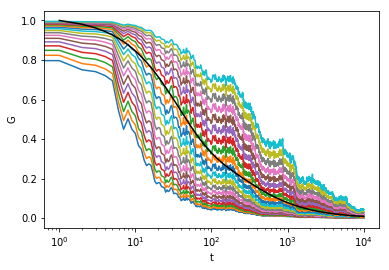

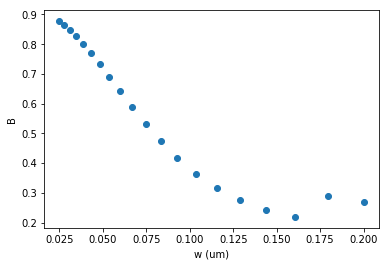

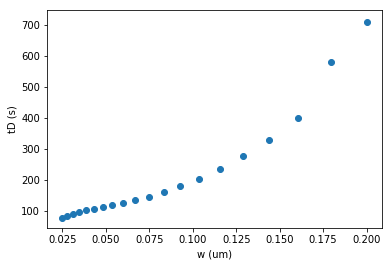

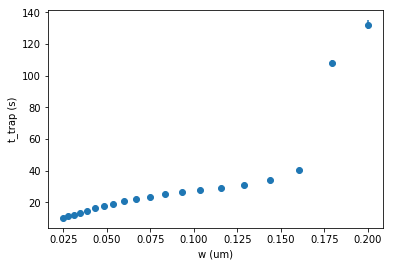

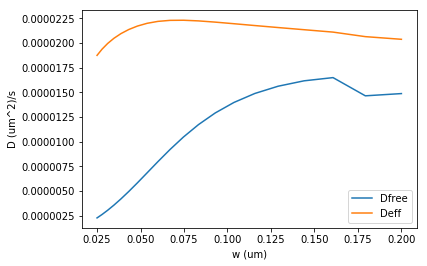

In [89]:
# _traj = p_avg
# _traj = Lo_avg
_traj = Ld_avg

print(len(_traj))
ts = [x for x in np.arange(1,len(_traj))]

# w_range = np.linspace(20,175,20) #For MSD
# w_range = np.logspace(np.log10(20), np.log10(500), 20)
# w_range = np.linspace(.025,0.2,20) # For Lo, in micrometers (same units as data)
w_range = np.logspace(np.log10(.025), np.log10(.2), 20)

# time_scaling = 1 # for MSD
# time_scaling = 1./5. # for Lo ??? 

plt.xscale('log')

calced_Ds = []

Bs, tDs, ttraps = [], [], []

popts = []
perrs = []

print("ranging over %s" % w_range)

for w in w_range:
    
    print("Calculating for w = %.2e" % w, end='\r')

    # Experimental reshaping of acorrs to fill 0-1
    acorrs = [acorr(t*2e-5, _traj[t], w) for t in ts]

    acorrs /= max(acorrs)

    plt.plot(acorrs)
    plt.xlabel('t')
    plt.ylabel('G')

    
    
    popt, pcov = curve_fit(trap_acorr, ts, acorrs, p0=(.1,.1,1), bounds=[0,np.inf])
    perr = np.sqrt(np.diag(pcov))
    
    print("B: {:.2e} | tD: {:.2e} | t_trap: {:.2e}".format(*popt))
    print("Err: B: {:.2e} | tD: {:.2e} | t_trap: {:.2e}".format(*perr))
#     print(perr)
    
#     calced_D = w**2. / (4.*popt[1])
    calced_Dfree = w**2 / (4 *(popt[1]-popt[0]*popt[2]))
    calced_Deff = w**2 / (4 * (1-popt[0]) * (popt[1]-popt[0]*popt[2]))

    calced_Ds.append((calced_Dfree, calced_Deff))
    
#     popts.append(popt)
#     perrs.append(perr)

    Bs.append((popt[0], perr[0]))
    tDs.append((popt[1],perr[1]))
    ttraps.append((popt[2], perr[2]))
    

Bs = list(map(list, zip(*Bs)))
tDs = list(map(list, zip(*tDs)))
ttraps = list(map(list, zip(*ttraps)))
calced_Ds = list(map(list, zip(*calced_Ds)))

print("Average diffusion constant was %.2e | %.2e" % (np.mean(calced_Ds[0]), np.mean(calced_Ds[1])))
print("Average trap time was %.2e" % np.mean(ttraps[0]))
print("Average diffusion time was %.2e" % np.mean(tDs[0]))
print("Average Beta was %.2e" % np.mean(Bs[0]))

avg_acorrs = [trap_acorr(x, np.mean(Bs[0]), np.mean(tDs[0]), np.mean(ttraps[0])) for x in range(len(ts))]

plt.plot(ts, avg_acorrs, 'k-')
    
plt.figure(2)
plt.errorbar(w_range, Bs[0], fmt='o', yerr=Bs[1])
plt.ylabel('B')
plt.xlabel('w (um)')

plt.figure(3)
plt.errorbar(w_range, tDs[0], fmt='o', yerr=tDs[1])
plt.ylabel('tD (s)')
plt.xlabel('w (um)')

plt.figure(4)
plt.errorbar(w_range, ttraps[0], fmt='o', yerr=ttraps[1])
plt.ylabel('t_trap (s)')
plt.xlabel('w (um)')

plt.figure(5)
plt.plot(w_range, calced_Ds[0],  label="Dfree")
plt.plot(w_range, calced_Ds[1],  label="Deff")
plt.ylabel('D (um^2)/s')
plt.xlabel('w (um)')
plt.legend()

# print(Bs[1][:10])
# print(tDs[1][:10])
# print(ttraps[1][:10])
    
# print(calced_Ds)
# avgD = np.mean(calced_Ds)
# errD = np.std(calced_Ds)

# plt.plot(w_range, calced_Ds)

# plt.plot(w_range, [avgD]*len(w_range), label="D = {:.2e}".format(avgD))
# plt.plot(w_range, [avgD + errD]*len(w_range), 'r--')
# plt.plot(w_range, [avgD - errD]*len(w_range), 'r--')

# plt.xlabel('w')
# plt.ylabel('D')
plt.legend()